<a href="https://colab.research.google.com/github/BZ6/PINDeepLearning/blob/lab4/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%964.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этой лабораторной работе ваша задача состоит в ознакомлении с GAN.


In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

Первая задача - это простая отработка генеративной архитектуры. Необходимо, взяв за основу датасет https://www.kaggle.com/datasets/zalando-research/fashionmnist, получить на выходе сети подобные входным изображения. Архитектуру генератора и дискриминатора подбирайте самостоятельно.

In [ ]:
def load_fashion_mnist(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    return train_loader

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size * 4)
        self.fc2 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.fc3 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.bn1 = nn.BatchNorm1d(hidden_size * 4)
        self.bn2 = nn.BatchNorm1d(hidden_size * 2)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.tanh(self.fc4(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2)
        self.fc3 = nn.Linear(hidden_size * 2, hidden_size * 4)
        self.fc4 = nn.Linear(hidden_size * 4, 1)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size * 2)
        self.bn3 = nn.BatchNorm1d(hidden_size * 4)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.sigmoid(self.fc4(x))
        return x

In [ ]:
def train_gan(num_epochs=200, batch_size=64, lr=0.0002):
    train_loader = load_fashion_mnist(batch_size)

    generator = Generator(input_size=100, hidden_size=256, output_size=784).cuda()
    discriminator = Discriminator(input_size=784, hidden_size=256).cuda()

    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=lr)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(train_loader):
            batch_size = images.size(0)
            real_images = images.view(batch_size, -1).cuda()
            real_labels = torch.ones(batch_size, 1).cuda()
            fake_labels = torch.zeros(batch_size, 1).cuda()

            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs

            z = torch.randn(batch_size, 100).cuda()
            fake_images = generator(z)
            outputs = discriminator(fake_images)
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs

            d_loss = d_loss_real + d_loss_fake
            optimizer_d.zero_grad()
            d_loss.backward()
            optimizer_d.step()

            z = torch.randn(batch_size, 100).cuda()
            fake_images = generator(z)
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)

            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()

            if (i+1) % 900 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}, D(x): {real_score.mean().item()}, D(G(z)): {fake_score.mean().item()}')

    torch.save(generator.state_dict(), 'generator.pth')
    torch.save(discriminator.state_dict(), 'discriminator.pth')

train_gan()

Epoch [1/200], Step [900/938], d_loss: 0.4157086908817291, g_loss: 2.5537750720977783, D(x): 0.8255569934844971, D(G(z)): 0.17091281712055206
Epoch [2/200], Step [900/938], d_loss: 0.1536620855331421, g_loss: 3.26625657081604, D(x): 0.946675717830658, D(G(z)): 0.0861082524061203
Epoch [3/200], Step [900/938], d_loss: 0.10063166171312332, g_loss: 4.057661056518555, D(x): 0.9611260294914246, D(G(z)): 0.05575987696647644
Epoch [4/200], Step [900/938], d_loss: 0.33702367544174194, g_loss: 3.3752365112304688, D(x): 0.9341186881065369, D(G(z)): 0.2103748619556427
Epoch [5/200], Step [900/938], d_loss: 0.12518475949764252, g_loss: 3.009260416030884, D(x): 0.9446084499359131, D(G(z)): 0.05611838772892952
Epoch [6/200], Step [900/938], d_loss: 0.11388333141803741, g_loss: 2.8569300174713135, D(x): 0.9571393132209778, D(G(z)): 0.032565366476774216
Epoch [7/200], Step [900/938], d_loss: 0.1417115181684494, g_loss: 2.616483449935913, D(x): 0.9736491441726685, D(G(z)): 0.09444023668766022
Epoch [8/

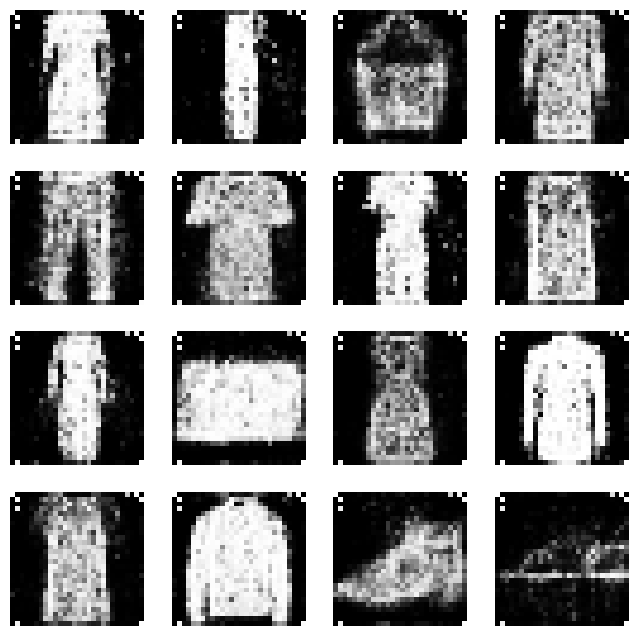

In [ ]:
def visualize_results():
    generator = Generator(input_size=100, hidden_size=256, output_size=784).cuda()
    generator.load_state_dict(torch.load('generator.pth'))
    generator.eval()

    z = torch.randn(16, 100).cuda()
    fake_images = generator(z)
    fake_images = fake_images.view(16, 28, 28)

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(fake_images[i].cpu().detach().numpy(), cmap='gray')
        ax.axis('off')
    plt.show()

visualize_results()

Зачача №2 сосстоит в повышении качества изображения. Предлагается использовать две разные архитектуры: обычный автоэнкодер и генеративно-состязательную сеть. Здесь предлагается выбрать любой датасет, состоящий из изображений желательно в трех цветовых каналах, но можно взять и черно-белые, однако в любом случае исходные изображения должны быть в разрешении хотя бы 300х300 и представлять собой композиции (иначе говоря - быть "сложными". Подойдут, например, любые фотографии тех же кошек/собак). Датасет здесь состоит из изображений исходного размера, которые пойдут на выход, и их сжатых копий, которые пойдут на вход сети (просто скукожьте исходники с помощью resize в 2 или 4 раза). Отделите часть датасета для теста (не валидации!) и после обучения нейронной сети примените её к сжатым изображениям тестовой выборки. Результат применения выведете на экран. Не обязательно брать изображения в высоком разрешении,

Автоэнкодер:

Зачача №2 сосстоит в повышении качества изображения. Предлагается использовать две разные архитектуры: обычный автоэнкодер и генеративно-состязательную сеть. Здесь предлагается выбрать любой датасет, состоящий из изображений желательно в трех цветовых каналах, но можно взять и черно-белые, однако в любом случае исходные изображения должны быть в разрешении хотя бы 300х300 и представлять собой композиции (иначе говоря - быть "сложными". Подойдут, например, любые фотографии тех же кошек/собак). Датасет здесь состоит из изображений исходного размера, которые пойдут на выход, и их сжатых копий, которые пойдут на вход сети (просто скукожьте исходники с помощью resize в 2 или 4 раза). Отделите часть датасета для теста (не валидации!) и после обучения нейронной сети примените её к сжатым изображениям тестовой выборки. Результат применения выведете на экран. Не обязательно брать изображения в высоком разрешении,

In [ ]:
def load_data(batch_size=64, resize_factor=2):
    transform = transforms.Compose([
        transforms.Resize((32 // resize_factor, 32 // resize_factor)),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

Автоэнкодер:

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def train_autoencoder(num_epochs=20, batch_size=64, lr=0.001):
    train_loader, _ = load_data(batch_size)

    autoencoder = Autoencoder().cuda()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(train_loader):
            images = images.cuda()
            outputs = autoencoder(images)
            loss = criterion(outputs, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 200 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    torch.save(autoencoder.state_dict(), 'autoencoder.pth')

In [ ]:
def denormalize(images):
    return (images / 2 + 0.5).clamp(0, 1)

def visualize_autoencoder():
    _, test_loader = load_data(batch_size=16)

    autoencoder = Autoencoder().cuda()
    autoencoder.load_state_dict(torch.load('autoencoder.pth'))
    autoencoder.eval()

    for images, _ in test_loader:
        images = images.cuda()
        outputs = autoencoder(images)
        break

    images = denormalize(images)
    outputs = denormalize(outputs)

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].cpu().detach().numpy().transpose(1, 2, 0))
        ax.axis('off')
    plt.show()

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(outputs[i].cpu().detach().numpy().transpose(1, 2, 0))
        ax.axis('off')
    plt.show()

GAN:

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size * 4)
        self.fc2 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.fc3 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.bn1 = nn.BatchNorm1d(hidden_size * 4)
        self.bn2 = nn.BatchNorm1d(hidden_size * 2)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.tanh(self.fc4(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2)
        self.fc3 = nn.Linear(hidden_size * 2, hidden_size * 4)
        self.fc4 = nn.Linear(hidden_size * 4, 1)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size * 2)
        self.bn3 = nn.BatchNorm1d(hidden_size * 4)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.sigmoid(self.fc4(x))
        return x

In [ ]:
def train_gan(num_epochs=50, batch_size=64, lr=0.0002):
    train_loader, _ = load_data(batch_size)

    generator = Generator(input_size=100, hidden_size=256, output_size=3*32*32).cuda()
    discriminator = Discriminator(input_size=3*32*32, hidden_size=256).cuda()

    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=lr)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(train_loader):
            batch_size = images.size(0)
            real_images = images.view(batch_size, -1).cuda()
            real_labels = torch.ones(batch_size, 1).cuda()
            fake_labels = torch.zeros(batch_size, 1).cuda()

            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs

            z = torch.randn(batch_size, 100).cuda()
            fake_images = generator(z)
            outputs = discriminator(fake_images)
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs

            d_loss = d_loss_real + d_loss_fake
            optimizer_d.zero_grad()
            d_loss.backward()
            optimizer_d.step()

            z = torch.randn(batch_size, 100).cuda()
            fake_images = generator(z)
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)

            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()

            if (i+1) % 200 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}, D(x): {real_score.mean().item()}, D(G(z)): {fake_score.mean().item()}')

    torch.save(generator.state_dict(), 'generator.pth')
    torch.save(discriminator.state_dict(), 'discriminator.pth')

In [ ]:
def visualize_gan():
    generator = Generator(input_size=100, hidden_size=256, output_size=3*32*32).cuda()
    generator.load_state_dict(torch.load('generator.pth'))
    generator.eval()

    z = torch.randn(16, 100).cuda()
    fake_images = generator(z)
    fake_images = fake_images.view(16, 3, 32, 32)
    fake_images = denormalize(fake_images)

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(fake_images[i].cpu().detach().numpy().transpose(1, 2, 0))
        ax.axis('off')
    plt.show()

Обучение:

In [ ]:
train_autoencoder()

100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


Epoch [1/20], Step [200/782], Loss: 0.014246158301830292
Epoch [1/20], Step [400/782], Loss: 0.01011616364121437
Epoch [1/20], Step [600/782], Loss: 0.006254981271922588
Epoch [2/20], Step [200/782], Loss: 0.004661377985030413
Epoch [2/20], Step [400/782], Loss: 0.0033282265067100525
Epoch [2/20], Step [600/782], Loss: 0.0028388022910803556
Epoch [3/20], Step [200/782], Loss: 0.0023842353839427233
Epoch [3/20], Step [400/782], Loss: 0.0027399188838899136
Epoch [3/20], Step [600/782], Loss: 0.0021481853909790516
Epoch [4/20], Step [200/782], Loss: 0.001938510686159134
Epoch [4/20], Step [400/782], Loss: 0.001737299608066678
Epoch [4/20], Step [600/782], Loss: 0.002043859101831913
Epoch [5/20], Step [200/782], Loss: 0.0014255632413551211
Epoch [5/20], Step [400/782], Loss: 0.0014296374283730984
Epoch [5/20], Step [600/782], Loss: 0.001585320569574833
Epoch [6/20], Step [200/782], Loss: 0.0012960713356733322
Epoch [6/20], Step [400/782], Loss: 0.001226017251610756
Epoch [6/20], Step [600/

In [ ]:
train_gan()

100%|██████████| 170M/170M [00:13<00:00, 12.2MB/s]


Epoch [1/50], Step [200/782], d_loss: 0.6720068454742432, g_loss: 1.5211405754089355, D(x): 0.6832612156867981, D(G(z)): 0.22552648186683655
Epoch [1/50], Step [400/782], d_loss: 0.3038119673728943, g_loss: 2.0410404205322266, D(x): 0.8656081557273865, D(G(z)): 0.14095282554626465
Epoch [1/50], Step [600/782], d_loss: 0.5284199714660645, g_loss: 2.3439841270446777, D(x): 0.7707471251487732, D(G(z)): 0.17448818683624268
Epoch [2/50], Step [200/782], d_loss: 0.2898479104042053, g_loss: 2.7530903816223145, D(x): 0.861562967300415, D(G(z)): 0.12389100342988968
Epoch [2/50], Step [400/782], d_loss: 0.24044106900691986, g_loss: 2.563347816467285, D(x): 0.9091051816940308, D(G(z)): 0.12473814189434052
Epoch [2/50], Step [600/782], d_loss: 0.23050808906555176, g_loss: 2.4523181915283203, D(x): 0.9249186515808105, D(G(z)): 0.1315610557794571
Epoch [3/50], Step [200/782], d_loss: 0.25643569231033325, g_loss: 3.0024566650390625, D(x): 0.87472003698349, D(G(z)): 0.08316975831985474
Epoch [3/50], S

Визуализация результата:

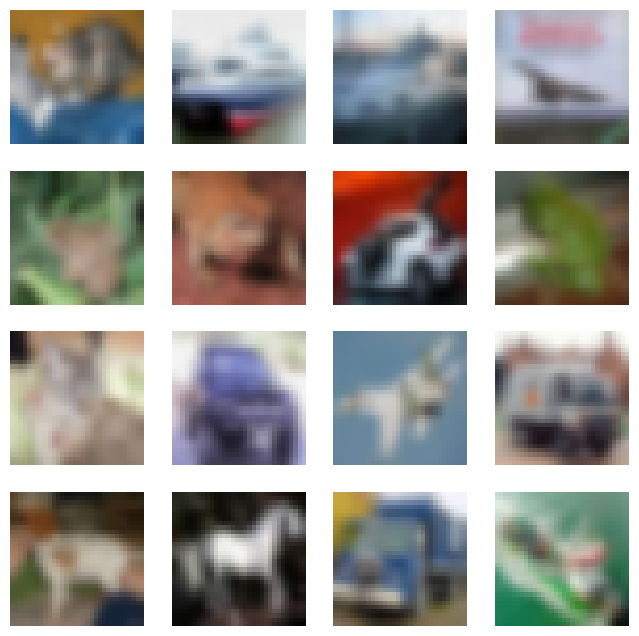

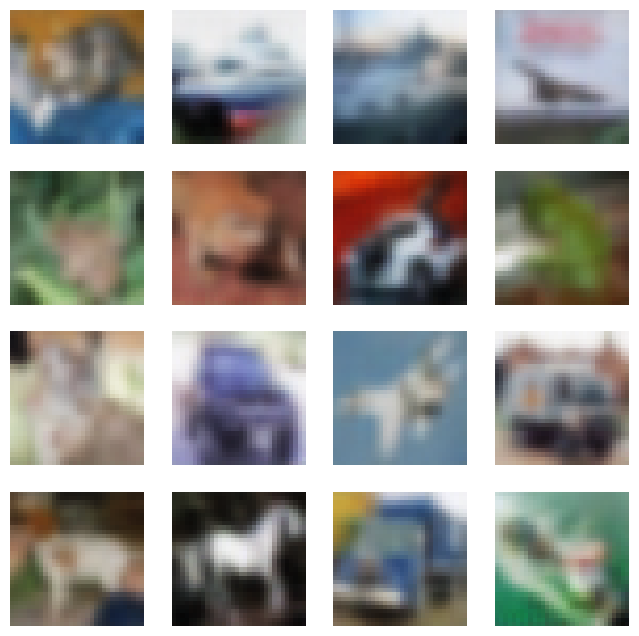

In [ ]:
visualize_autoencoder()

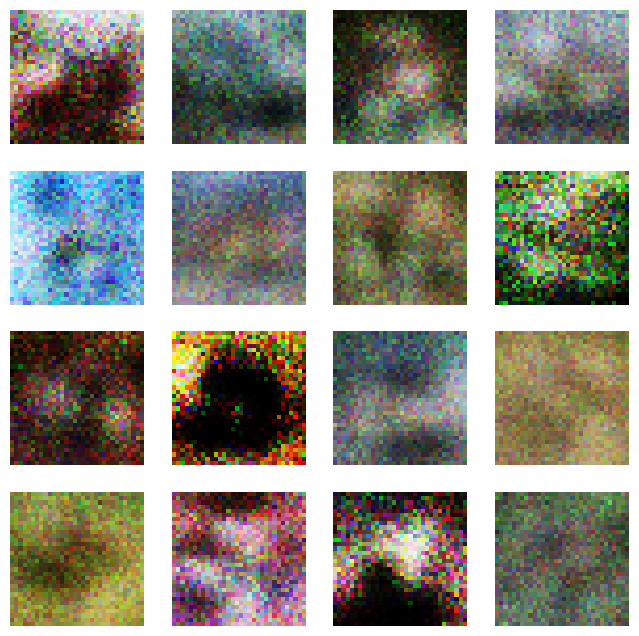

In [ ]:
visualize_gan()